# importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [2]:
import pandas as pd

# Loading the  data file without headers
data_train_X = pd.read_csv("readable_datasets/amino_acids_train.txt", header=None)

# printing the head of the data
print(data_train_X.head())

                                                   0
0  F D Y Q T V Y F A N Q Y G L R T I E L G E S E ...
1  R P E S E L I R Q S W R V V S R S P L E H G T ...
2  M K I A I L G A G C Y R T H A A A G I T N F M ...
3  R R T V P R G T L R K I I K K H K P H L R L A ...
4  Q V E I S X A E W D V X N I I W D K K S V S A ...


In [3]:
# loading all the data files
data_train_y = pd.read_csv("readable_datasets/pss_train.txt", header=None)
data_test_X = pd.read_csv("readable_datasets/amino_acids_test.txt", header=None)
data_test_y = pd.read_csv("readable_datasets/pss_test.txt", header=None)

# Data analysis

In [4]:
print(data_test_X.head())
print(data_train_y.head())
print(data_test_y.head())

                                                   0
0  V P S L A T I S L E N S W S G L S K Q I Q L A ...
1  M F K V Y G Y D S N I H K C V Y C D N A K R L ...
2  T P E M P V L E N R A A Q G N I T A P G G A R ...
3  A P A F S V S P A S G A S D G Q S V S V S V A ...
4  T P A F N K P K V E L H V H L D G A I K P E T ...
                                                   0
0  L L L L E E E L S L S E E E E E E E L S L L S ...
1  L L S H H H H H H H H H H H H T S H H H H H H ...
2  L E E E E E L L L L S H H H H H H L L L L L H ...
3  L L L L L H H H H H H H H H H H L T T L L L L ...
4  L L L L L H H H H H H H H H H H H S S S E E H ...
                                                   0
0  L L L H H H H H H H H H H H H H H H H H H H H ...
1  L E E E E E L L T T T S L L H H H H H H H H H ...
2  L L L L L L L L L L S L L S L T T S T T T T L ...
3  L L E E E E E L L S S L L S S L E E E E E E E ...
4  L L S L L S L E E E E E E E G G G S L L H H H ...


In [5]:
# analysing the shape of the data


print(data_train_X.shape) 

(5534, 1)


In [6]:
print(data_train_y.shape)

(5534, 1)


In [7]:
print(data_test_X.shape)

(514, 1)


In [8]:
print(data_test_y.shape)

(514, 1)


In [9]:
# checking for null values
print(data_train_X.isna().sum()) 
print(data_train_y.isna().sum())
print(data_test_X.isna().sum()) 
print(data_test_y.isna().sum()) 

0    0
dtype: int64
0    0
dtype: int64
0    0
dtype: int64
0    0
dtype: int64


# Data preprocessing

In [10]:
# `data_train_X` and `data_test_X` have only one column, converting them to list
amino_acids_train = data_train_X.iloc[:, 0].tolist()
amino_acid_test = data_test_X.iloc[:, 0].tolist()
print("Extracted sequence successfully.")

Extracted sequence successfully.


In [11]:
# print(amino_acids_train)
# print(amino_acids_test)

In [12]:
# coverting the pss data to list
pss_train = data_train_y.iloc[:, 0].tolist()
pss_test = data_test_y.iloc[:, 0].tolist()
print("Extracted sequence successfully.")

Extracted sequence successfully.


In [13]:
# Spliting the sequence into a list of amino acids
amino_acids_train_tokens = [list(seq) for seq in amino_acids_train]
amino_acids_test_tokens = [list(seq) for seq in amino_acid_test]

In [14]:
# Defining parameters for Word2Vec
embedding_dim = 50

# Training the Word2Vec model
word2vec_model = Word2Vec(sentences=amino_acids_train_tokens, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [15]:
# defining a function to extract embeddings from amino acids
def sequence_to_embedding(sequence, model, embedding_dim):
    """Convert amino acid sequence to embedding using Word2Vec model."""
    return np.array([model.wv[aa] if aa in model.wv else np.zeros(embedding_dim) for aa in sequence])

# extracting the emeddings of training and testing data
train_embeddings = [sequence_to_embedding(seq, word2vec_model, embedding_dim) for seq in amino_acids_train_tokens]
test_embeddings = [sequence_to_embedding(seq, word2vec_model, embedding_dim) for seq in amino_acids_test_tokens]

# Padding the embeddings to make the input consistent
max_len = max(len(seq) for seq in amino_acids_train_tokens + amino_acids_test_tokens)
train_embeddings = pad_sequences(train_embeddings, maxlen=max_len, dtype='float32', padding='post')
test_embeddings = pad_sequences(test_embeddings, maxlen=max_len, dtype='float32', padding='post')

In [16]:
# Verifying unique secondary structure classes before encoding
unique_pss_labels_train = set("".join(pss_train))
unique_pss_labels_test = set("".join(pss_test))
print("Unique labels in training data (pss_train) before encoding:", unique_pss_labels_train)
print("Unique labels in test data (pss_test) before encoding:", unique_pss_labels_test)

Unique labels in training data (pss_train) before encoding: {'S', 'I', 'B', 'T', 'L', 'H', ' ', 'G', 'E'}
Unique labels in test data (pss_test) before encoding: {'S', 'I', 'B', 'T', 'L', 'H', ' ', 'G', 'E'}


In [17]:
# Removing the spaces from the training and testing sets
pss_train = [seq.replace(" ", "") for seq in pss_train]
pss_test = [seq.replace(" ", "") for seq in pss_test]

# Verifying the unique labels after removing spaces
unique_pss_labels_train = set("".join(pss_train))
unique_pss_labels_test = set("".join(pss_test))
print("Unique labels in training data (pss_train) after removing spaces:", unique_pss_labels_train)
print("Unique labels in test data (pss_test) after removing spaces:", unique_pss_labels_test)

# defining the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_pss_labels_train | unique_pss_labels_test))  # Fit on combined unique labels from both sets

# Applying the encoding
pss_train_encoded = [label_encoder.transform(list(seq)) for seq in pss_train]
pss_test_encoded = [label_encoder.transform(list(seq)) for seq in pss_test]

# Verifying the unique classes after label encoding encoding
print("Unique encoded labels in training data:", np.unique(np.concatenate(pss_train_encoded)))
print("Unique encoded labels in test data:", np.unique(np.concatenate(pss_test_encoded)))

# padding the encoded labels for model training
pss_train_encoded = pad_sequences(pss_train_encoded, maxlen=max_len, padding='post')
pss_test_encoded = pad_sequences(pss_test_encoded, maxlen=max_len, padding='post')

# Converting the padded sequence t0 one-hot encoding labels
pss_train_onehot = to_categorical(pss_train_encoded, num_classes=len(label_encoder.classes_))
pss_test_onehot = to_categorical(pss_test_encoded, num_classes=len(label_encoder.classes_))

# Printing the shape of test and train set after one-hot encoding
print("Shape of one-hot encoded training labels:", pss_train_onehot.shape)
print("Shape of one-hot encoded test labels:", pss_test_onehot.shape)

Unique labels in training data (pss_train) after removing spaces: {'S', 'I', 'B', 'T', 'L', 'H', 'G', 'E'}
Unique labels in test data (pss_test) after removing spaces: {'S', 'I', 'B', 'T', 'L', 'H', 'G', 'E'}
Unique encoded labels in training data: [0 1 2 3 4 5 6 7]
Unique encoded labels in test data: [0 1 2 3 4 5 6 7]
Shape of one-hot encoded training labels: (5534, 1399, 8)
Shape of one-hot encoded test labels: (514, 1399, 8)


# Model training

In [18]:
# Defining the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(max_len, embedding_dim)),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(len(label_encoder.classes_), activation='softmax'))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training of the model
model1 = model.fit(train_embeddings, pss_train_onehot, validation_data=(test_embeddings, pss_test_onehot), epochs=10, batch_size=32)

Epoch 1/10
173/173 [==============================] - 411s 2s/step - loss: 0.7046 - accuracy: 0.8363 - val_loss: 0.3529 - val_accuracy: 0.8838
Epoch 2/10
173/173 [==============================] - 696s 4s/step - loss: 0.4504 - accuracy: 0.8514 - val_loss: 0.3447 - val_accuracy: 0.8878
Epoch 3/10
173/173 [==============================] - 405s 2s/step - loss: 0.4537 - accuracy: 0.8523 - val_loss: 0.3891 - val_accuracy: 0.8907
Epoch 4/10
173/173 [==============================] - 376s 2s/step - loss: 0.4645 - accuracy: 0.8478 - val_loss: 0.3490 - val_accuracy: 0.8851
Epoch 5/10
173/173 [==============================] - 378s 2s/step - loss: 0.4509 - accuracy: 0.8513 - val_loss: 0.3496 - val_accuracy: 0.8859
Epoch 6/10
173/173 [==============================] - 382s 2s/step - loss: 0.4473 - accuracy: 0.8526 - val_loss: 0.3440 - val_accuracy: 0.8882
Epoch 7/10
173/173 [==============================] - 382s 2s/step - loss: 0.4425 - accuracy: 0.8535 - val_loss: 0.3480 - val_accuracy: 0.8867

In [19]:
# Evaluating the model
loss, accuracy = model.evaluate(test_embeddings, pss_test_onehot)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

17/17 [==============================] - 12s 692ms/step - loss: 0.3007 - accuracy: 0.8948
Test Accuracy: 89.48%


In [20]:

y_pred = model.predict(test_embeddings)
y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
y_test_labels = np.argmax(pss_test_onehot, axis=-1).flatten()

17/17 [==============================] - 13s 673ms/step


In [21]:
# printing the classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

Classification Report:


C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           B       0.96      0.98      0.97    635502
           E       0.18      0.00      0.00     18016
           G       0.00      0.00      0.00      3132
           H       0.26      0.64      0.37     26157
           I       0.00      0.00      0.00        30
           L       0.49      0.07      0.12     17920
           S       0.00      0.00      0.00      8316
           T       0.00      0.00      0.00     10013

    accuracy                           0.89    719086
   macro avg       0.24      0.21      0.18    719086
weighted avg       0.87      0.89      0.87    719086



C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Training and Validation Loss')

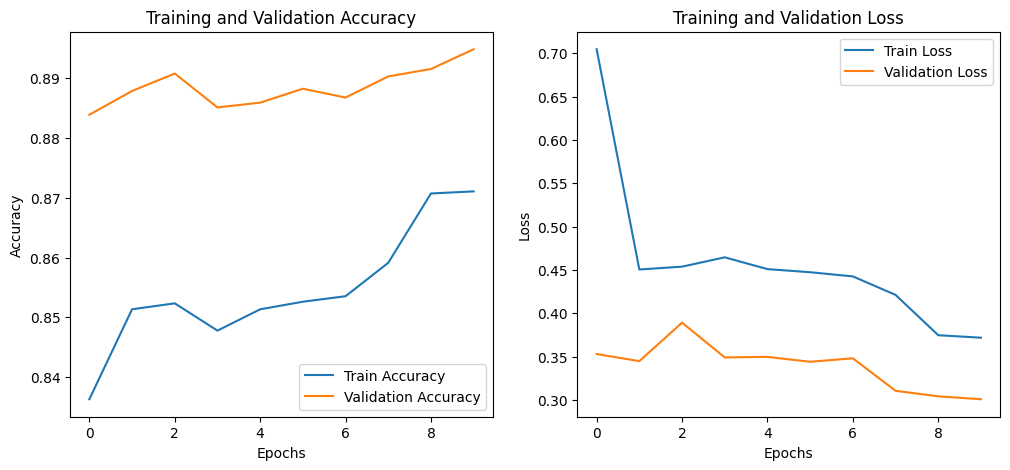

In [22]:
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(model1.history['accuracy'], label='Train Accuracy')
plt.plot(model1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(model1.history['loss'], label='Train Loss')
plt.plot(model1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Hyperparametric tuning - BiLSTM with Attention Mechanism

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Bidirectional, Input, Attention
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Defining the input shape and dimension for the model
input_shape = (max_len, embedding_dim)
num_classes = len(label_encoder.classes_)

# Building the enhanced model
model2 = Sequential([
    # BiLSTM layer with 128 units
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    Dropout(0.3),  # Dropout layer for regularization
    
    # To enhance the learning adding another BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    # TimeDistributed Dense layer with attention
    TimeDistributed(Dense(64, activation='relu')),
    
    # For focusing on important parts, attention layer is included
    TimeDistributed(Dense(32, activation='relu')),
    
    # Output layer with softmax activation for multi-class classification
    TimeDistributed(Dense(num_classes, activation='softmax'))
])

# Compiling the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Defining early stopping regularization for better generalization
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [19]:

# Training of the model
training2 = model2.fit(
    train_embeddings, pss_train_onehot,
    validation_data=(test_embeddings, pss_test_onehot),
    epochs=20,  #  20 epochs
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
173/173 [==============================] - 1274s 7s/step - loss: 0.5006 - accuracy: 0.8546 - val_loss: 0.2485 - val_accuracy: 0.9118
Epoch 2/20
173/173 [==============================] - 1029s 6s/step - loss: 0.2984 - accuracy: 0.8883 - val_loss: 0.2167 - val_accuracy: 0.9155
Epoch 3/20
173/173 [==============================] - 1051s 6s/step - loss: 0.2761 - accuracy: 0.8947 - val_loss: 0.2102 - val_accuracy: 0.9179
Epoch 4/20
173/173 [==============================] - 1080s 6s/step - loss: 0.2699 - accuracy: 0.8963 - val_loss: 0.2086 - val_accuracy: 0.9175
Epoch 5/20
173/173 [==============================] - 1080s 6s/step - loss: 0.2661 - accuracy: 0.8972 - val_loss: 0.2075 - val_accuracy: 0.9183
Epoch 6/20
173/173 [==============================] - 1082s 6s/step - loss: 0.2646 - accuracy: 0.8976 - val_loss: 0.2080 - val_accuracy: 0.9185
Epoch 7/20
173/173 [==============================] - 1121s 6s/step - loss: 0.2630 - accuracy: 0.8980 - val_loss: 0.2057 - val_accuracy:

In [20]:
# Evaluating the model
loss2, accuracy2 = model2.evaluate(test_embeddings, pss_test_onehot)
print(f"Test Accuracy2: {accuracy2 * 100:.2f}%")

17/17 [==============================] - 25s 1s/step - loss: 0.2024 - accuracy: 0.9189
Test Accuracy2: 91.89%


In [22]:

y_pred2 = model2.predict(test_embeddings)
y_pred_labels2 = np.argmax(y_pred2, axis=-1).flatten()
y_test_labels = np.argmax(pss_test_onehot, axis=-1).flatten()

17/17 [==============================] - 24s 1s/step


In [23]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels2, target_names=label_encoder.classes_))

Classification Report:


C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           B       1.00      1.00      1.00    635502
           E       0.35      0.02      0.03     18016
           G       0.00      0.00      0.00      3132
           H       0.32      0.96      0.48     26157
           I       0.00      0.00      0.00        30
           L       0.60      0.05      0.10     17920
           S       0.00      0.00      0.00      8316
           T       0.00      0.00      0.00     10013

    accuracy                           0.92    719086
   macro avg       0.28      0.25      0.20    719086
weighted avg       0.92      0.92      0.90    719086



C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Training and Validation Loss')

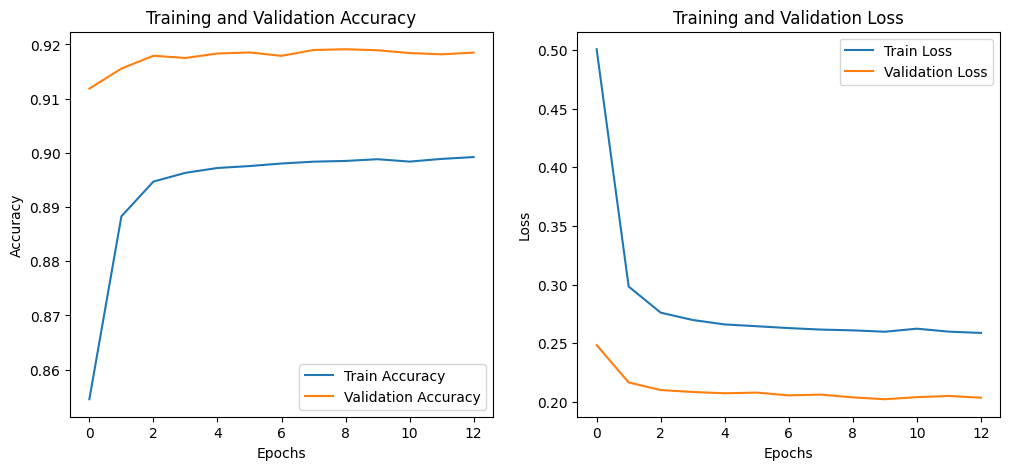

In [31]:
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(training2.history['accuracy'], label='Train Accuracy')
plt.plot(training2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(training2.history['loss'], label='Train Loss')
plt.plot(training2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')